# Домашнее задание

Lvl 1:

 - взять подготовленные раннее данные из задачи Titanic, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
 - кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр grid в GridSearchCV )
 - определить самые важные фичи
 - вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

Результат: скрины нового сабмита на Kaggle и построенного дерева

In [52]:
import os
print(os.listdir("../input"))

['test.csv', 'train.csv', 'gender_submission.csv']


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [54]:
data = pd.read_csv("../input/train.csv")
data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [55]:
df_test = pd.read_csv("../input/test.csv")
df_test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


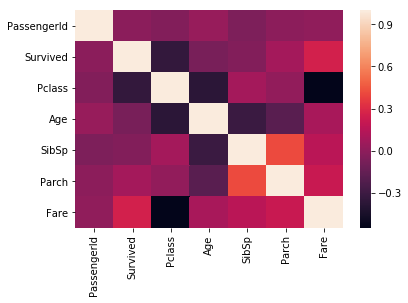

In [56]:
sns.heatmap(data.corr()) # проверим признаки на корреляцию

In [57]:
y_train = data['Survived'].copy()   # TRAIN Y
df_train = data.drop('Survived', axis=1)

## Preprocessing data

In [58]:
df_train['is_train'] = 1
df_test['is_train'] = 0
df_all = pd.concat([df_train, df_test])

In [59]:
df_all.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_train
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1


In [60]:
df_all.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,is_train
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000
mean,655.000000,2.294882,29.881138,0.498854,0.385027,33.295479,0.680672
std,378.020061,0.837836,14.413493,1.041658,0.865560,51.758668,0.466394
min,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,982.000000,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


In [61]:
df_all['is_male'] = df_all['Sex'].replace({'male': 1, 'female': 0})
df_all = df_all.drop('Sex', axis=1)

In [62]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
is_train       1309 non-null int64
is_male        1309 non-null int64
dtypes: float64(2), int64(6), object(4)
memory usage: 132.9+ KB


In [63]:
# Заполним пропуски "Cabin", так как скорее всего это это что то может значить
df_all['Cabin'] = df_all['Cabin'].fillna('NaN')
df_all['Cabin'] = df_all['Cabin'].apply(lambda x: x[0])

In [64]:
df_all['Cabin'].value_counts(normalize=True)

N    0.774637
C    0.071811
B    0.049656
D    0.035141
E    0.031322
A    0.016807
F    0.016043
G    0.003820
T    0.000764
Name: Cabin, dtype: float64

In [65]:
df_all = df_all.drop('Ticket', axis=1)

In [66]:
df_all.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Fare,Cabin,Embarked,is_train,is_male
0,1,3,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,N,S,1,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,C,C,1,0
2,3,3,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,N,S,1,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,C,S,1,0
4,5,3,"Allen, Mr. William Henry",35.0,0,0,8.0500,N,S,1,1


Проверяем важность фичей, которые можем получить из имени



In [67]:
df_all['Name'] = df_all['Name'].apply(lambda x: x.strip().split()[1])

In [68]:
df_all['Name'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Planke,', 'Don.', 'Rev.',
       'Billiard,', 'der', 'Walle,', 'Dr.', 'Pelsmaeker,', 'Mulder,', 'y',
       'Steen,', 'Carlo,', 'Mme.', 'Impe,', 'Ms.', 'Major.', 'Gordon,',
       'Messemaeker,', 'Mlle.', 'Col.', 'Capt.', 'Velde,', 'the',
       'Shawah,', 'Jonkheer.', 'Melkebeke,', 'Cruyssen,', 'Khalil,',
       'Palmquist,', 'Brito,'], dtype=object)

In [69]:
# Все аббревиатуры не заканчивающиеся точкой отправим в другое

df_all['Name'] = df_all['Name'].apply(lambda x: x if x[-1] == '.' else 'other')

In [70]:
df_all['Name'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'other', 'Don.', 'Rev.', 'Dr.',
       'Mme.', 'Ms.', 'Major.', 'Mlle.', 'Col.', 'Capt.', 'Jonkheer.'],
      dtype=object)

In [71]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth = 5)

In [72]:
from collections import Counter

In [73]:
one_big_text = " ".join(df_all['Name'])
words = one_big_text.split()
most_common = Counter(words).most_common()
most_common

[('Mr.', 736),
 ('Miss.', 256),
 ('Mrs.', 191),
 ('Master.', 59),
 ('other', 37),
 ('Rev.', 8),
 ('Dr.', 8),
 ('Col.', 4),
 ('Ms.', 2),
 ('Major.', 2),
 ('Mlle.', 2),
 ('Don.', 1),
 ('Mme.', 1),
 ('Capt.', 1),
 ('Jonkheer.', 1)]

In [74]:
abbr = pd.DataFrame()
for col, num in most_common:
    abbr[col] = df_all[df_all['is_train'] == 1]['Name'].str.contains(col).astype(int)

In [75]:
clf.fit(abbr, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [76]:
df_all['Name'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'other', 'Don.', 'Rev.', 'Dr.',
       'Mme.', 'Ms.', 'Major.', 'Mlle.', 'Col.', 'Capt.', 'Jonkheer.'],
      dtype=object)

In [77]:
clf.feature_importances_

array([0.54990181, 0.05675211, 0.360356  , 0.        , 0.01383008,
       0.01916   , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

Видим что на предсказания влияют только самые распространённые признаки (Mr, Mrs...). Тогда выделим топ-5 признаком, остальные отправим в другие

In [78]:
df_all['Name'].value_counts()

Mr.          736
Miss.        256
Mrs.         191
Master.       59
other         37
Rev.           8
Dr.            8
Col.           4
Mlle.          2
Ms.            2
Major.         2
Mme.           1
Jonkheer.      1
Don.           1
Capt.          1
Name: Name, dtype: int64

In [79]:
top_names = df_all['Name'].value_counts().head()
df_all['Name'] = df_all['Name'].apply(lambda x: x if x in top_names else 'other')

In [80]:
df_all['Name'].value_counts(normalize=True)

Mr.        0.562261
Miss.      0.195569
Mrs.       0.145913
other      0.051184
Master.    0.045073
Name: Name, dtype: float64

Заполним оставшиеся пропуски пропуски 

In [81]:
from sklearn.preprocessing import Imputer

In [82]:
imp = Imputer(strategy='mean')
df_all['Age'] = imp.fit_transform(df_all[['Age']]).ravel()
df_all['Fare'] = imp.fit_transform(df_all[['Fare']]).ravel()

Избавляемся от категориальных признаков

In [83]:
df_all = pd.get_dummies(df_all, ['Embarked', 'Name', 'Cabin'], drop_first=False, dummy_na=False)

In [84]:
df_all.head(5)

,PassengerId,Pclass,Age,SibSp,Parch,Fare,is_train,is_male,Embarked_Master.,Embarked_Miss.,Embarked_Mr.,Embarked_Mrs.,Embarked_other,Name_A,Name_B,Name_C,Name_D,Name_E,Name_F,Name_G,Name_N,Name_T,Cabin_C,Cabin_Q,Cabin_S
0,1,3,22.0,1,0,7.2500,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,2,1,38.0,1,0,71.2833,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
2,3,3,26.0,0,0,7.9250,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,4,1,35.0,1,0,53.1000,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
4,5,3,35.0,0,0,8.0500,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [85]:
df_all.isnull().sum()

PassengerId         0
Pclass              0
Age                 0
SibSp               0
Parch               0
Fare                0
is_train            0
is_male             0
Embarked_Master.    0
Embarked_Miss.      0
Embarked_Mr.        0
Embarked_Mrs.       0
Embarked_other      0
Name_A              0
Name_B              0
Name_C              0
Name_D              0
Name_E              0
Name_F              0
Name_G              0
Name_N              0
Name_T              0
Cabin_C             0
Cabin_Q             0
Cabin_S             0
dtype: int64

In [86]:
df_all[df_all['is_train']==1].shape, df_all[df_all['is_train']==0].shape

((891, 25), (418, 25))

Разделим train и test. Подберем лучшие параметры и обучим дерево

In [87]:
df_train = df_all[df_all['is_train']==1]
df_test = df_all[df_all['is_train']==0]

In [88]:
df_train = df_train.drop('is_train', axis=1)
df_test = df_test.drop('is_train', axis=1)

In [89]:
df_train.shape, y_train.shape

((891, 24), (891,))

In [90]:
from sklearn.model_selection import GridSearchCV
tree = DecisionTreeClassifier()

In [91]:
max_depth = [3, 4, 5, 7, 9, 11, 15] 
min_samples_leaf = np.arange(3,13)
param_grid = { 'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}

In [92]:
tree_grid = GridSearchCV(tree, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

In [93]:
tree_grid.fit(df_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 4, 5, 7, 9, 11, 15], 'min_samples_leaf': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [94]:
print (tree_grid.best_params_)
print (tree_grid.best_score_)

{'max_depth': 7, 'min_samples_leaf': 6}
0.8159371492704826


In [95]:
tree_clf = tree_grid.best_estimator_

In [96]:
for i, j in zip(tree_clf.feature_importances_, df_train.columns):
    print("{:.2f}   {:10}".format(i, j))

0.06   PassengerId
0.13   Pclass    
0.08   Age       
0.06   SibSp     
0.00   Parch     
0.08   Fare      
0.49   is_male   
0.03   Embarked_Master.
0.00   Embarked_Miss.
0.00   Embarked_Mr.
0.00   Embarked_Mrs.
0.00   Embarked_other
0.00   Name_A    
0.00   Name_B    
0.00   Name_C    
0.00   Name_D    
0.00   Name_E    
0.00   Name_F    
0.00   Name_G    
0.06   Name_N    
0.00   Name_T    
0.00   Cabin_C   
0.01   Cabin_Q   
0.00   Cabin_S   


после просмотра важности фичей, видим что многие признаки можно было бы убрать

In [97]:
y_pred = tree_clf.predict(df_test)

Теперь нарисуем дерево

In [98]:
from sklearn.tree import export_graphviz

In [99]:
tree_clf.classes_

array([0, 1])

In [106]:
export_graphviz(tree_clf, out_file='titanic_tree_.dot', filled=True, feature_names=df_train.columns, \
                class_names=list(['Death', 'Survived']))

In [107]:
!dot -Tpng titanic_tree_.dot -o titanic_tree_.png

<img src='titanic_tree_.png'>